In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
simple_log, middle_log, full_log = simple_like(logX=True), middle_like(logX=True), full_like(logX=True)
from aeons.hessian import hess_autograd

In [2]:
def get_logprs(ds, logpr, *args):
    logprs = np.zeros_like(ds)
    for i, d in enumerate(ds):
        logprs[i] = logpr(*args, d)
    return logprs
def linear_step(X, theta, steps=10):
    return theta * np.floor(X * steps)/steps

In [4]:
nk = 500 * np.ones(1000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

### Quad

(array([252.06665039]), array([-1.53479608]))

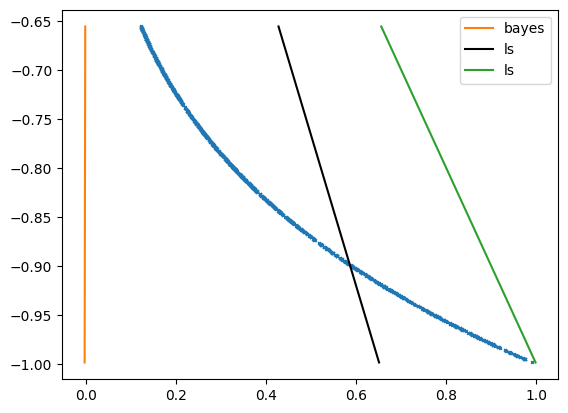

In [281]:
X = generate_Xs(nk)
theta_true = 10
y = simple.func(X, theta_true)
theta_b = minimise_bayes(y, linear, mean_X, covinv_X, theta_true).x
theta_l = minimise_ls(y, linear, mean_X, theta_true).x
plt.plot(X, y, 'x', ms=2)
plt.plot(linear.inverse(y, theta_b), y, label='bayes')
plt.plot(linear.inverse(y, theta_l), y, label='ls', color='black')
plt.plot(linear.inverse(y, -1), y, label='ls')
plt.legend();
theta_b, theta_l

### Linear step

(array([14.39611816]), array([8.89891466]))

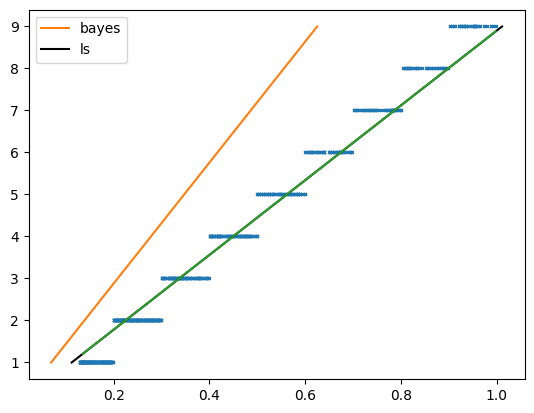

In [31]:
X = generate_Xs(nk)
theta_true = 10
y = linear_step(X, theta_true, 10)
theta_b = minimise_bayes(y, linear, mean_X, covinv_X, theta_true).x
theta_l = minimise_ls(y, linear, mean_X, theta_true).x
plt.plot(X, y, 'x', ms=2)
plt.plot(linear.inverse(y, theta_b), y, label='bayes')
plt.plot(linear.inverse(y, theta_l), y, label='ls', color='black')
plt.plot(mean_X, linear.func(mean_X, theta_l))
plt.legend();
theta_b, theta_l

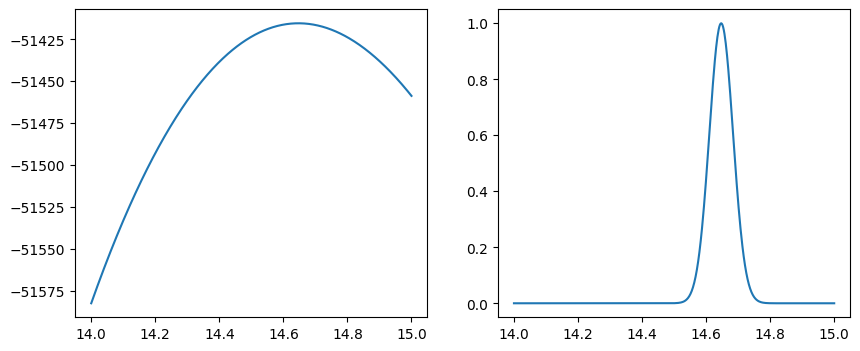

In [29]:
ds = np.linspace(14, 15, 500)
logprs = get_logprs(ds, logPr_bayes, y, linear, mean_X, covinv_X)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(ds, logprs)
ax2.plot(ds, np.exp(logprs-logprs.max()));

### Simple step

In [5]:
nk = 500 * np.ones(1000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
mean_logX = logX_mu(nk)
covinv_logX = logX_Sigmainv(nk)

In [92]:
def wedding_like_simple(X, theta):
    d = theta
    def i(x):
        """Plateau number of a parameter point."""
        r = abs(x)
        return np.floor(d*np.log(r))
    def logL(x):
        """Gaussian log-likelihood."""
        ri = np.exp((i(x)/d))
        return - ri**(2/d)
    return logL(X)

In [126]:
theta_true = 10
X = generate_Xs(nk)
y = wedding_like_simple(X, theta_true)
theta_b = minimise_bayes(y, simple, mean_X, covinv_X, 9).x
theta_b

array([0.81073608])

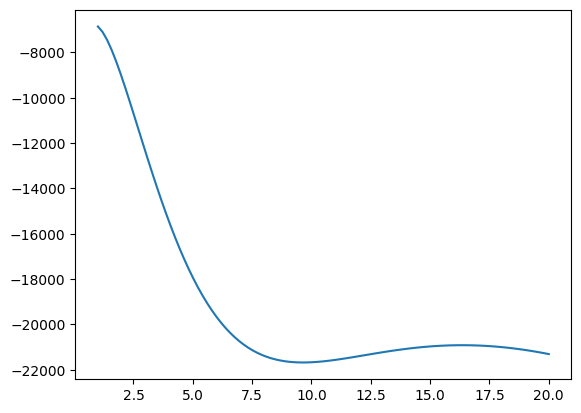

In [145]:
ds = np.linspace(1, 20, 100)
logprs = get_logprs(ds, logPr_bayes, y, simple, mean_X, covinv_X)
plt.plot(ds, logprs)

In [136]:
theta_ls = minimise_ls(y, simple, mean_X, 10).x

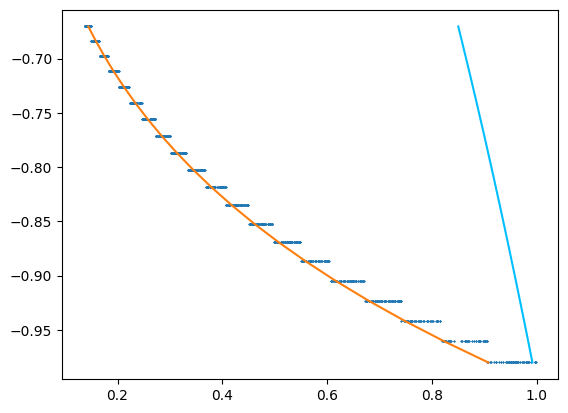

In [144]:
plt.plot(X, y, 'x', ms=1)
plt.plot(simple.inverse(y, theta_b), y, color='deepskyblue')
plt.plot(simple.inverse(y, theta_ls), y)
# plt.plot(X, -X**(2/d)/(2*sigma**2));